# **Twitter U.S. Airline Sentiment Project**

## **Background & Objective**

### **Problem Statement**
Sentiment analysis/classification, which involves monitoring emotions in conversations on social media platforms such as Twitter, has become a key strategy in social media marketing.

Listening to how customers feel about the product/service on Twitter allows companies to understand their audience, keep on top of what’s being said about their brand and their competitors, and discover new trends in the industry.

Implement the NLP techniques learned as a part of the course.


In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## **Install & Import Pertinent Libraries**

In [2]:
!pip install contractions

In [3]:
# import necessary libraries.

import re, string, unicodedata                          # Import Regex, string and unicodedata.
import contractions                                     # Import contractions library.
from bs4 import BeautifulSoup                           # Import BeautifulSoup.

import numpy as np                                      # Import numpy.
import pandas as pd                                     # Import pandas.
import matplotlib.pyplot as plt                         
import seaborn as sns

import nltk                                             # Import Natural Language Tool-Kit.

# Download Stopwords
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

from nltk.corpus import stopwords                       # Import stopwords.
from nltk.tokenize import word_tokenize, sent_tokenize  # Import Tokenizer.
from nltk.stem.wordnet import WordNetLemmatizer         # Import Lemmatizer.
from wordcloud import WordCloud,STOPWORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier       # Import Random forest Classifier
from sklearn.metrics import classification_report         # Import Classification report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold , StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

# Ignore the warnings
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## **Load & Inspect Dataset**

In [4]:
# load dataset into dataframe
tweet_data = pd.read_csv('/content/drive/My Drive/Tweets.csv')

In [5]:
data = tweet_data.copy()   # copy data to preserve original dataset

In [6]:
data.head()   # check first 5 rows

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [7]:
data.sample(10)   # check data sample

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
1257,569864290578108419,negative,1.0000,Bad Flight,0.6804,United,NaN,JohntheKiwi,NaN,0,"@united You can't control turbulence, but you ...",NaN,2015-02-23 06:20:09 -0800,"Stumptown, Baby!",Pacific Time (US & Canada)
7674,569358956549681152,negative,1.0000,Customer Service Issue,0.6946,Delta,NaN,jrcoonley,NaN,0,@JetBlue that is not what your employee at Log...,NaN,2015-02-21 20:52:08 -0800,NaN,Quito
97,569907336485019648,negative,1.0000,Can't Tell,0.6590,Virgin America,NaN,MustBeSpoken,NaN,0,@VirginAmerica - Let 2 scanned in passengers l...,NaN,2015-02-23 09:11:12 -0800,NaN,NaN
6492,567818783616954369,negative,0.6477,Late Flight,0.6477,Southwest,NaN,Cody_Butler,NaN,0,@SouthwestAir can I get any kind of update on ...,NaN,2015-02-17 14:52:02 -0800,"College Station, Texas",Central Time (US & Canada)
11008,568619609101721601,negative,0.6315,Late Flight,0.3281,US Airways,NaN,Allisonjones704,NaN,0,@USAirways that's the 1st sorry I received fro...,NaN,2015-02-19 19:54:13 -0800,NaN,NaN
14143,569661761449791488,negative,1.0000,Cancelled Flight,1.0000,American,NaN,2tsieRole,NaN,0,@AmericanAir My flight to @dfwairport was Canc...,NaN,2015-02-22 16:55:22 -0800,I'm everywhere.,Brasilia
12938,569975659730051072,negative,1.0000,Customer Service Issue,1.0000,American,NaN,RHFIT,NaN,0,@AmericanAir already shared with them. Nothing...,NaN,2015-02-23 13:42:41 -0800,NaN,NaN
3588,568250065845944321,neutral,1.0000,NaN,NaN,United,NaN,Belendelcanto,NaN,0,@united DCA-EWR Flight #4372,NaN,2015-02-18 19:25:47 -0800,Seattle,Hawaii
6645,567748089805799425,negative,1.0000,Lost Luggage,1.0000,Southwest,NaN,9ad16006a6014a6,NaN,0,@SouthwestAir can i have my bags back ding!!,NaN,2015-02-17 10:11:07 -0800,NaN,NaN
12526,570126389279662080,negative,1.0000,Customer Service Issue,1.0000,American,NaN,tennesseejc,NaN,0,@AmericanAir I responded. Your info different ...,NaN,2015-02-23 23:41:38 -0800,"las vegas/nashville, TN",Central Time (US & Canada)


In [8]:
data.shape   # check data shape (rows and columns)

(14640, 15)

In [9]:
data.info()   # check for missing values and feature data types

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

In [10]:
data.isnull().sum()   # check missing value count

tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64

In [11]:
# get unique value counts of each column

def return_unique_values(data_frame):
    unique_dataframe = pd.DataFrame()
    unique_dataframe['Features'] = data_frame.columns
    uniques = []
    for col in data_frame.columns:
        u = data_frame[col].nunique()
        uniques.append(u)
    unique_dataframe['Uniques'] = uniques
    return unique_dataframe

unique_values = return_unique_values(data)
print(unique_values)

                        Features  Uniques
0                       tweet_id    14485
1              airline_sentiment        3
2   airline_sentiment_confidence     1023
3                 negativereason       10
4      negativereason_confidence     1410
5                        airline        6
6         airline_sentiment_gold        3
7                           name     7701
8            negativereason_gold       13
9                  retweet_count       18
10                          text    14427
11                   tweet_coord      832
12                 tweet_created    14247
13                tweet_location     3081
14                 user_timezone       85


In [12]:
data.describe()   # check data statistical summary

,tweet_id,airline_sentiment_confidence,negativereason_confidence,retweet_count
count,1.464000e+04,14640.000000,10522.000000,14640.000000
mean,5.692184e+17,0.900169,0.638298,0.082650
std,7.791112e+14,0.162830,0.330440,0.745778
min,5.675883e+17,0.335000,0.000000,0.000000
25%,5.685592e+17,0.692300,0.360600,0.000000
50%,5.694779e+17,1.000000,0.670600,0.000000
75%,5.698905e+17,1.000000,1.000000,0.000000
max,5.703106e+17,1.000000,1.000000,44.000000


#### **Observations**
- There are 14640 rows and 15 features.
- Lot of missing values in numerous columns however for the purpose of this analysis we are only interested in sentiment and text columns.
- Target variable is "airline_sentiment" having 3 classes: "positive", "negative" and "neutral".
- One thing to note before starting EDA, I would've liked to understand the process and criteria for classifying the sentiment for the tweets in the dataset. Interpretations can vary especially when tweets are laced with sarcasm or other undertones. 

## **Exploratory Data Analysis**

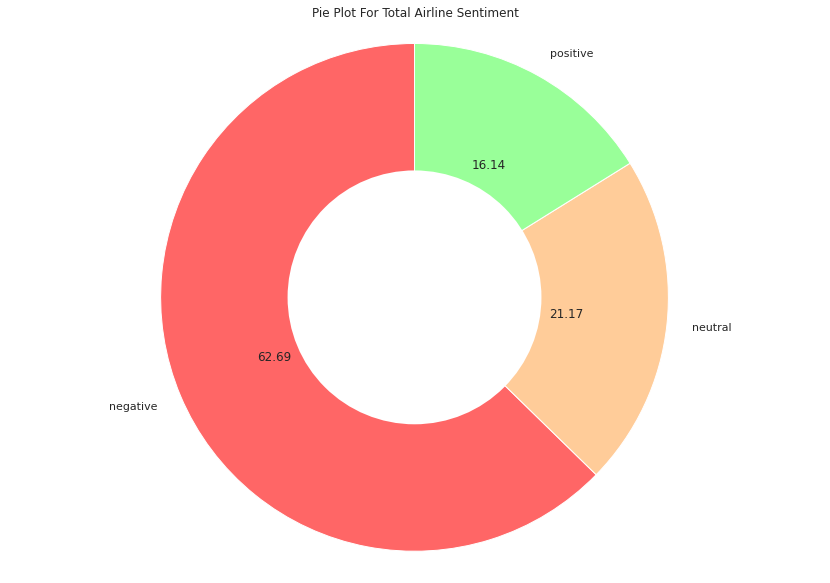

In [13]:
# plot breakdown of Total Airline Sentiment

colors = ['#ff6666', '#ffcc99', '#99ff99']

sns.set(rc={'figure.figsize':(11.7,8.27)})
plot = plt.pie(data['airline_sentiment'].value_counts(), labels=data['airline_sentiment'].value_counts().index, colors=colors, startangle=90,  autopct='%.2f')
centre_circle = plt.Circle((0,0),0.5,color='black', fc='white',linewidth=0)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.title('Pie Plot For Total Airline Sentiment')
plt.axis('equal')
plt.tight_layout()
plt.show()

#### **Observations**
- Largely negative sentiment at ~62%.
- Positive sentiment is only ~16% while neutral sentiment is about 22%.

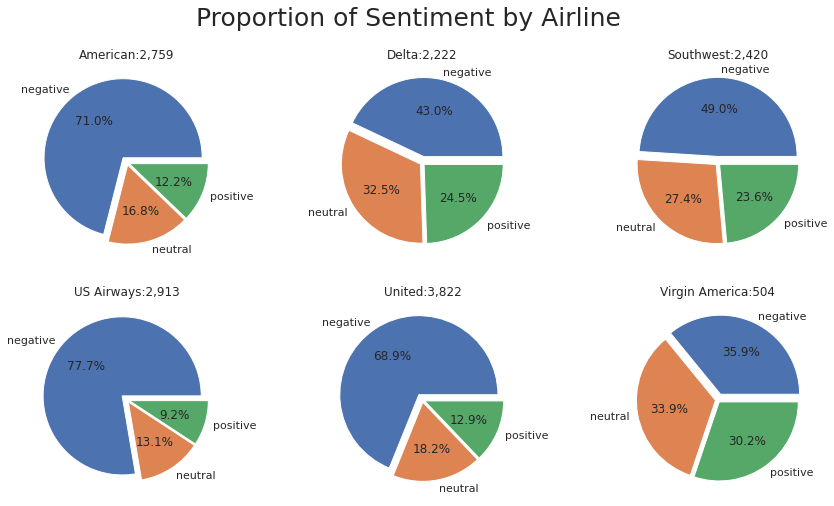

In [14]:
# plot proportion of sentiment by airline

a = data.groupby(['airline', 'airline_sentiment'])['airline_sentiment'].count().unstack()
# a['total'] =  [a.values[x].sum() for x in range(0,6)]

fig, axes = plt.subplots(2, 3, figsize = (15, 8))
axes = axes.flatten()
for i, ax in zip(range(0, 6), axes):
    temp = a.iloc[i]    
    ax.pie(x = temp, labels = temp.index, autopct = '%1.1f%%', explode = [0.08, 0.03, 0.03])
    ax.set_title(f"{a.index[i]}:{format(a.values[i].sum(),',')}")

plt.suptitle("Proportion of Sentiment by Airline", fontsize = 25)    
plt.show()

#### **Observations**
- Largely negative sentiment across all major airlines. 
- Most negative were for US Airways, American and United. 
- Least negative were for Southwest, Delta and Virgin America.

In [15]:
# function to create labeled barplots
def labeled_barplot(data, feature, title, pallet, perc=True, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(16, 4))
    else:
        plt.figure(figsize=(16, 4))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data[feature],
        palette=pallet,
        order=data[feature].value_counts().index[:20],
    )
    ax.set_title('Distribution of {} Tweeting About Airline'.format(title))

    for p in ax.patches:
        if perc == True:
            label = "{:1.2f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

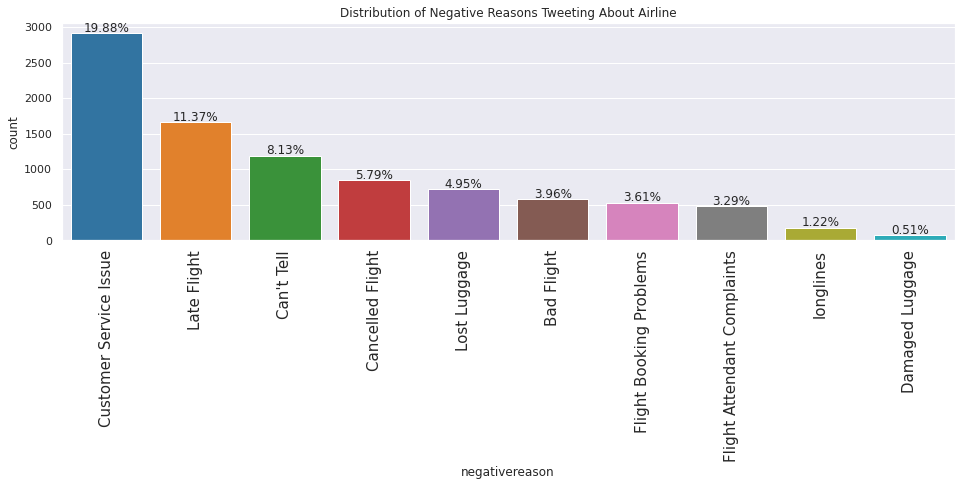

In [16]:
# visualize all negative reasons by percentage of tweets
labeled_barplot(data, 'negativereason', 'Negative Reasons', 'tab10')

#### **Observations**
- Top major complaint is related to airline customer service.
- Followed by flight delays and cancellations.

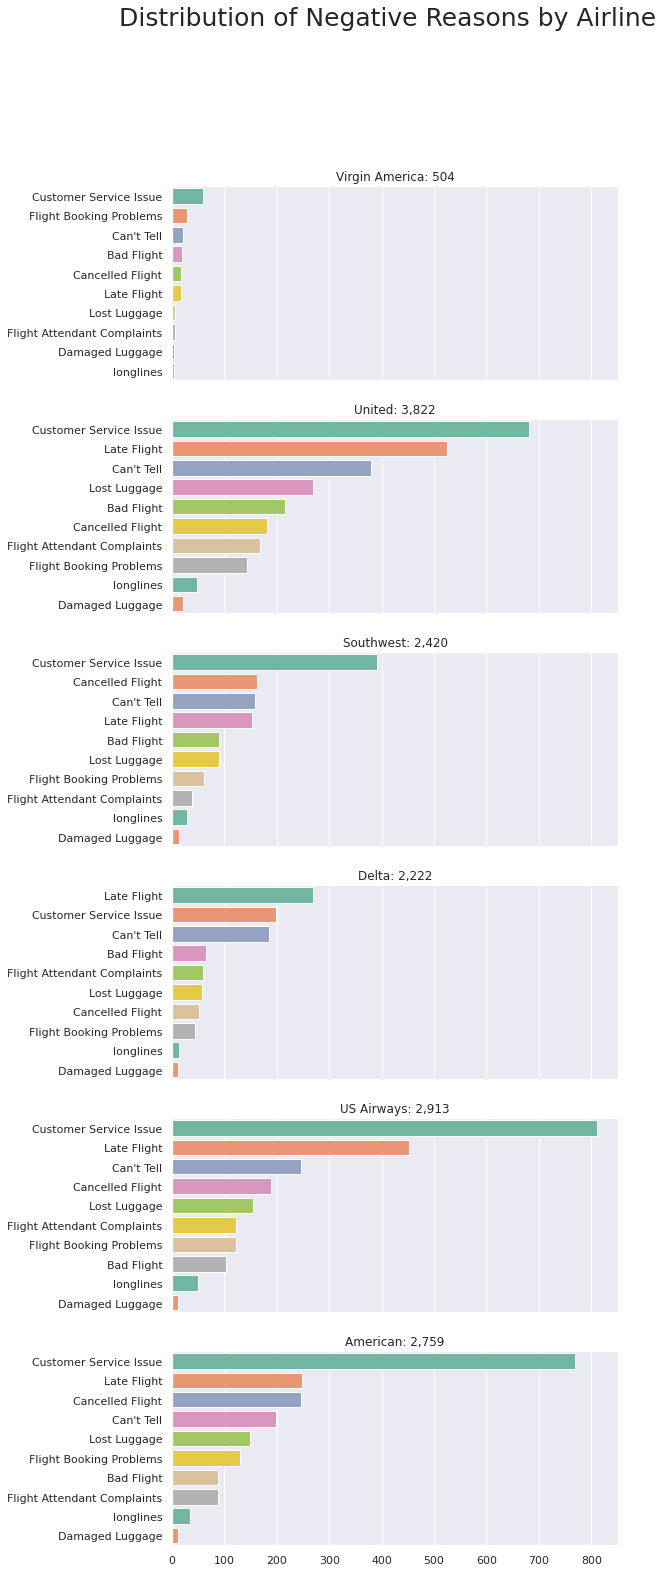

In [17]:
fig, axes = plt.subplots(6, 1, figsize=(8, 25), sharex=True)
axes = axes.flatten()
names = data['airline'].unique()

for name, n in zip(names, axes):
    ax = sns.countplot(data = data[data.airline==name], y = 'negativereason',
                       palette='Set2',
                       order = data[data.airline==name].negativereason.value_counts().index, ax=n)
#    ax.bar_label(ax.containers[0])
    ax.set_title(f"{name}: {format(len(data[data.airline==name]),',')}")
    ax.set_xlabel('')
    ax.set_ylabel('')

plt.suptitle("Distribution of Negative Reasons by Airline", fontsize = 25)
plt.show()

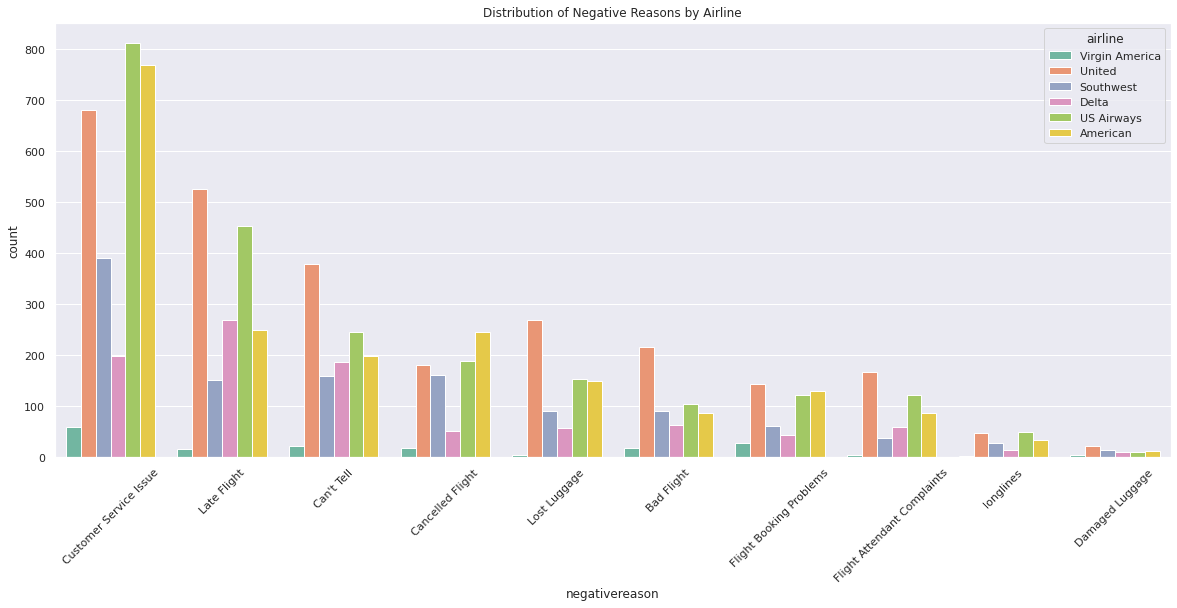

In [18]:
plt.figure(figsize=(20,8))
ax = sns.countplot(data = data, x = 'negativereason', palette='Set2',
                   order = data.negativereason.value_counts().index, hue = 'airline')

# ax.bar_label(ax.containers[0])
ax.set_title('Distribution of Negative Reasons by Airline')
plt.xticks(rotation=45)
plt.show()

#### **Observations**
- US Airways, American, United and Southwest getting dinged for bad customer service as top complaint by wide margin. 
- Top complaint for Delta is flight delays.

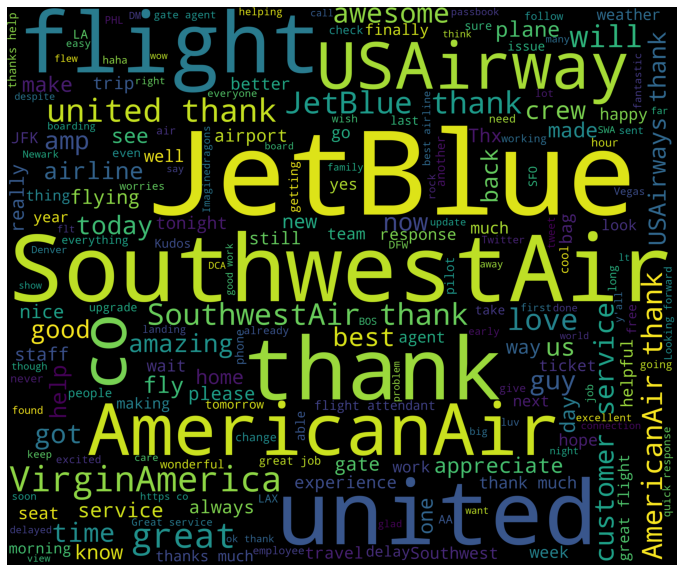

In [19]:
# create word cloud for positive reviews
positive_reviews = data[data['airline_sentiment'] == 'positive']
words = ' '.join(positive_reviews['text'])
cleaned_word = " ".join([word for word in words.split()])

positive_wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=3000,
                      height=2500
                     ).generate(cleaned_word)

plt.figure(1,figsize=(12, 12))
plt.imshow(positive_wordcloud)
plt.axis('off')
plt.show()

#### **Observations**
- "JetBlue" stands out as biggest and boldest term which indicates highest frequency of occurrence having positive association; even though it's not one of the airlines in the dataset. 
- Next most frequent is "SouthwestAir".
- "Thank" is a recurring word which is interesting to note.

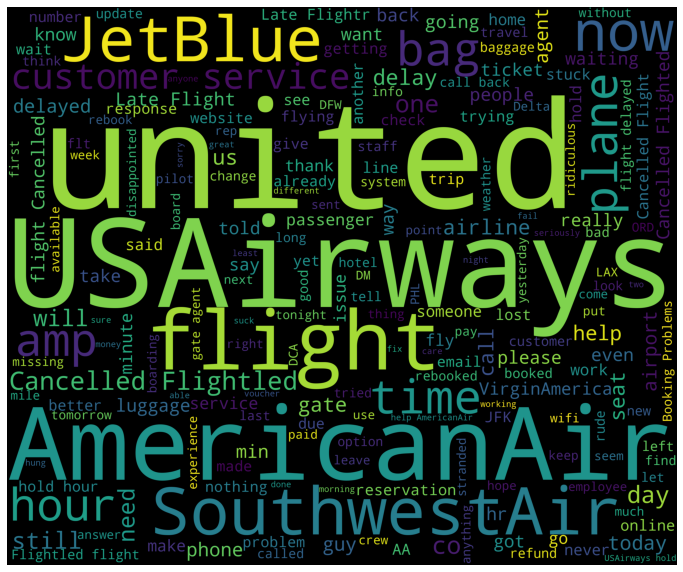

In [20]:
# create word cloud for negative reviews
negative_reviews = data[data['airline_sentiment'] == 'negative']
words = ' '.join(negative_reviews['text'])
cleaned_word = " ".join([word for word in words.split()])

negative_wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=3000,
                      height=2500
                     ).generate(cleaned_word)

plt.figure(1,figsize=(12, 12))
plt.imshow(negative_wordcloud)
plt.axis('off')
plt.show()

#### **Observations**
- "USAirways", "United" and "AmericanAir" stand out as highest frequency terms having negative association which does not come as a surprise based on previous EDA.
- Other words of interest are "time", "hour" and "now" which indicate issues with flight schedules and possibly delays. 

## **Data Preprocessing**

In [21]:
# drop all columns except for "airline_sentiment" and "text" for the purpose of this analysis

drop_cols = ['tweet_id', 'airline_sentiment_confidence', 'negativereason', 'negativereason_confidence', 'airline',
                'airline_sentiment_gold', 'name', 'negativereason_gold', 'retweet_count', 'tweet_coord', 'tweet_created',
                'tweet_location', 'user_timezone']

data.drop(drop_cols, axis = 1, inplace=True)

In [22]:
data.shape   # check new data shape

(14640, 2)

In [23]:
data.head()   # check first 5 rows after dropping columns

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


In [24]:
# clean up text

#remove the html tags
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")                    
    return soup.get_text()

#expand the contractions
def replace_contractions(text):
    return contractions.fix(text)

#remove the numericals present in the text
def remove_numbers(text):
  text = re.sub(r'\d+', '', text)
  return text

def clean_text(text):
    text = strip_html(text)
    text = replace_contractions(text)
    text = remove_numbers(text)
    return text

data['final_text'] = data['text'].apply(lambda x: clean_text(x))

In [25]:
data.head()   # check first 5 rows

,airline_sentiment,text,final_text
0,neutral,@VirginAmerica What @dhepburn said.,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...,@VirginAmerica plus you have added commercials...
2,neutral,@VirginAmerica I didn't today... Must mean I n...,@VirginAmerica I did not today... Must mean I ...
3,negative,@VirginAmerica it's really aggressive to blast...,@VirginAmerica it is really aggressive to blas...
4,negative,@VirginAmerica and it's a really big bad thing...,@VirginAmerica and it is a really big bad thin...


In [26]:
# tokenize the text data

data['final_text'] = data.apply(lambda row: nltk.word_tokenize(row['final_text']), axis=1) 

In [27]:
data.head()   # check first 5 rows after tokenization

,airline_sentiment,text,final_text
0,neutral,@VirginAmerica What @dhepburn said.,"[@, VirginAmerica, What, @, dhepburn, said, .]"
1,positive,@VirginAmerica plus you've added commercials t...,"[@, VirginAmerica, plus, you, have, added, com..."
2,neutral,@VirginAmerica I didn't today... Must mean I n...,"[@, VirginAmerica, I, did, not, today, ..., Mu..."
3,negative,@VirginAmerica it's really aggressive to blast...,"[@, VirginAmerica, it, is, really, aggressive,..."
4,negative,@VirginAmerica and it's a really big bad thing...,"[@, VirginAmerica, and, it, is, a, really, big..."


In [28]:
# further clean up of text data after tokenization

stopwords = stopwords.words('english')
stopwords = list(set(stopwords)) 
lemmatizer = WordNetLemmatizer()

#remove the non-ASCII characters
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

# convert all characters to lowercase
def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

# Remove the punctuations
def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

# Remove the stop words
def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopwords:
            new_words.append(word)
    return new_words

# lemmatize the words
def lemmatize_list(words):
    new_words = []
    for word in words:
      new_words.append(lemmatizer.lemmatize(word, pos='v'))
    return new_words

def normalize(words):
    words = remove_non_ascii(words)
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = remove_stopwords(words)
    words = lemmatize_list(words)
    return ' '.join(words)

#data['review'] = data['review'].astype(str)
data['final_text'] = data.apply(lambda row: normalize(row['final_text']), axis=1)

In [29]:
data.head()   # check first 5 rows after cleaning text

,airline_sentiment,text,final_text
0,neutral,@VirginAmerica What @dhepburn said.,virginamerica dhepburn say
1,positive,@VirginAmerica plus you've added commercials t...,virginamerica plus add commercials experience ...
2,neutral,@VirginAmerica I didn't today... Must mean I n...,virginamerica today must mean need take anothe...
3,negative,@VirginAmerica it's really aggressive to blast...,virginamerica really aggressive blast obnoxiou...
4,negative,@VirginAmerica and it's a really big bad thing...,virginamerica really big bad thing


## **Model Building & Evaluation**

### **Count Vectorizer**

In [30]:
# apply Count Vectorizer

count_vect = CountVectorizer(max_features=500)                # Keep only 500 features as number of features will increase the processing time.
data_features = count_vect.fit_transform(data['final_text'])

data_features = data_features.toarray() 

In [31]:
# assign independent and dependent variables

X = data_features
y = data['airline_sentiment']

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)   # split the dataset

In [33]:
# find optimal number of base learners using k-fold CV ->
base_ln = np.arange(100,500,100).tolist()
base_ln

[100, 200, 300, 400]

In [34]:
# perform K-Fold Cross Validation
cv_scores = []
for b in base_ln:
    rfc_count = RandomForestClassifier(n_estimators=b)
    scores = cross_val_score(rfc_count, X_train, y_train, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())

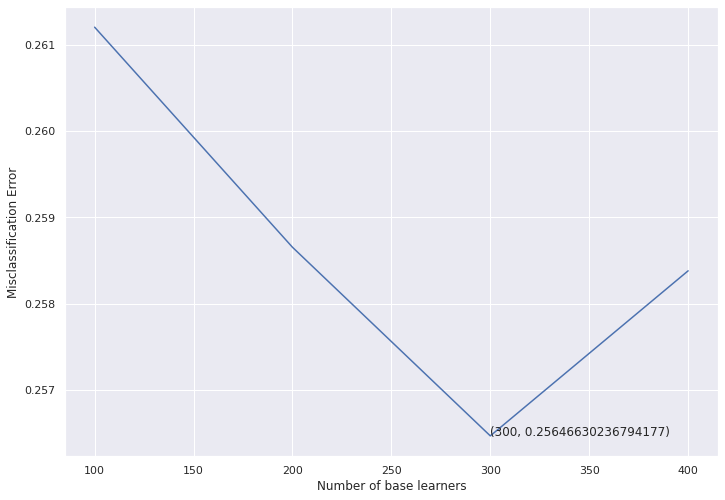

In [35]:
# plot error as k increases
error = [1 - x for x in cv_scores]                                 #error corresponds to each nu of estimator
optimal_learners = base_ln[error.index(min(error))]                #Selection of optimal nu of n_estimator corresponds to minimum error.
plt.plot(base_ln, error)                                           #Plot between each nu of estimator and misclassification error
xy = (optimal_learners, min(error))
plt.annotate('(%s, %s)' % xy, xy = xy, textcoords='data')
plt.xlabel("Number of base learners")
plt.ylabel("Misclassification Error")
plt.show()

In [36]:
# train best Random Forest model and calculate accuracy on test data
rfc_count = RandomForestClassifier(n_estimators=optimal_learners)
rfc_count.fit(X_train, y_train)
rfc_count.score(X_test, y_test)
count_predicted = rfc_count.predict(X_test)
print(classification_report(y_test, count_predicted, target_names = ['negative', 'neutral', 'positive']))
print("Accuracy of the model is : ", accuracy_score(y_test, count_predicted))

              precision    recall  f1-score   support

    negative       0.82      0.87      0.84      2291
     neutral       0.54      0.48      0.51       774
    positive       0.67      0.61      0.64       595

    accuracy                           0.74      3660
   macro avg       0.68      0.65      0.66      3660
weighted avg       0.74      0.74      0.74      3660

Accuracy of the model is :  0.7439890710382514


[[1989  214   88]
 [ 310  370   94]
 [ 133   98  364]]


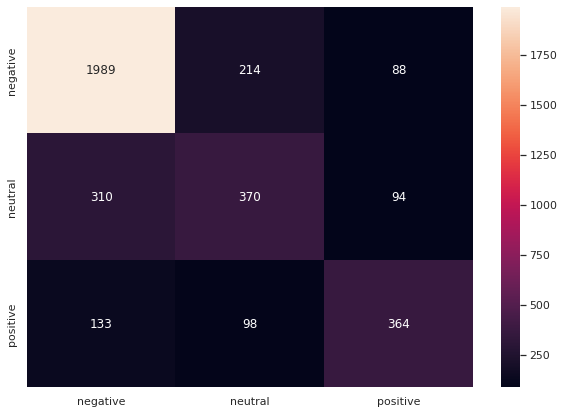

In [37]:
# print and plot Confusion matirx to get an idea of how the distribution of the prediction is, among all the classes.

conf_mat = confusion_matrix(y_test, count_predicted)

print(conf_mat)

df_cm = pd.DataFrame(conf_mat, index = [i for i in ['negative', 'neutral', 'positive']],
                  columns = [i for i in ['negative', 'neutral', 'positive']])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='g')

#### **Observations**
- Model performance is reasonable with accuracy at 74.4%.
- It seems that some tweets which were predicted to be "negative" are actually classified as "neutral".

thank,jetblue,flight,http,great,delay,usairways,unite,southwestair,get,love,hours,hold,americanair,awesome,cancel,bag,call,virginamerica,wait,would,go,please,amaze,fly,help,time,make,good,service,hour,customer,best,need,us,plane,one,airline,follow,still,
 
 


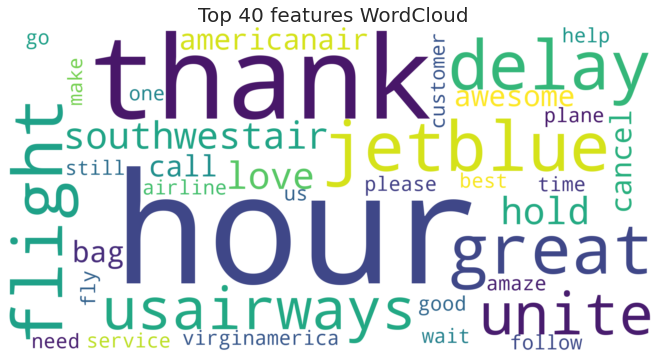

In [38]:
all_features = count_vect.get_feature_names()              #Instantiate the feature from the vectorizer
top_features=''                                            # Addition of top 40 feature into top_feature after training the model
feat = rfc_count.feature_importances_
features=np.argsort(feat)[::-1]
for i in features[0:40]:
    top_features+=all_features[i]
    top_features+=','
    
print(top_features)  

print(" ") 
print(" ")     

from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white",colormap='viridis',width=2000, 
                          height=1000).generate(top_features)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.figure(1, figsize=(14, 11), frameon='equal')
plt.title('Top 40 features WordCloud', fontsize=20)
plt.axis("off")
plt.show()

### **TFIDF Vectorizer**

In [39]:
# apply TFIDF Vectorizer

tfidf_vect = TfidfVectorizer(max_features=500)
data_features = tfidf_vect.fit_transform(data['final_text'])
data_features = data_features.toarray()

data_features.shape     #feature shape

(14640, 500)

In [40]:
# assign independent and dependent variables

X = data_features
y = data['airline_sentiment']

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)   # split the dataset

In [42]:
# find optimal number of base learners using k-fold CV ->
base_ln = np.arange(100,500,100).tolist()
base_ln

[100, 200, 300, 400]

In [43]:
# perform K-Fold Cross Validation
cv_scores = []
for b in base_ln:
    rfc_tfidf = RandomForestClassifier(n_estimators=b)
    scores = cross_val_score(rfc_tfidf, X_train, y_train, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())

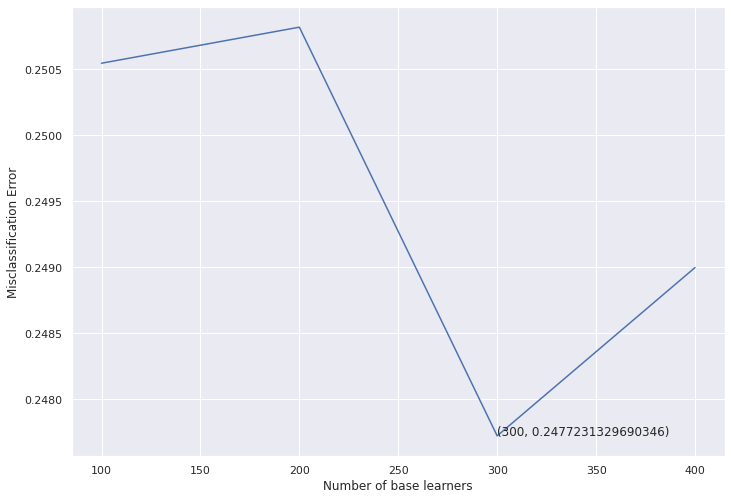

In [44]:
# plot error as k increases
error = [1 - x for x in cv_scores]                                 #error corresponds to each nu of estimator
optimal_learners = base_ln[error.index(min(error))]                #Selection of optimal nu of n_estimator corresponds to minimum error.
plt.plot(base_ln, error)                                           #Plot between each nu of estimator and misclassification error
xy = (optimal_learners, min(error))
plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.xlabel("Number of base learners")
plt.ylabel("Misclassification Error")
plt.show()

In [45]:
# train best Random Forest model and calculate accuracy on test data
rfc_tfidf = RandomForestClassifier(n_estimators=optimal_learners)
rfc_tfidf.fit(X_train, y_train)
rfc_tfidf.score(X_test, y_test)
tfidf_predicted = rfc_tfidf.predict(X_test)
print(classification_report(y_test, tfidf_predicted, target_names=['negative', 'neutral', 'positive']))
print("Accuracy of the model is : ", accuracy_score(y_test, tfidf_predicted))

              precision    recall  f1-score   support

    negative       0.79      0.91      0.85      2291
     neutral       0.58      0.41      0.48       774
    positive       0.72      0.55      0.62       595

    accuracy                           0.75      3660
   macro avg       0.69      0.62      0.65      3660
weighted avg       0.73      0.75      0.73      3660

Accuracy of the model is :  0.7475409836065574


[[2091  141   59]
 [ 385  318   71]
 [ 179   89  327]]


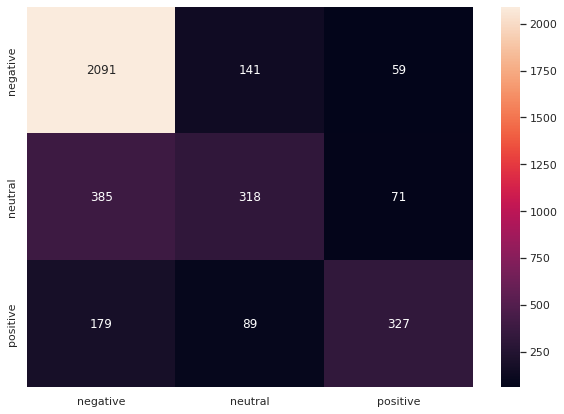

In [46]:
# print and plot Confusion matirx to get an idea of how the distribution of the prediction is, among all the classes.

conf_mat = confusion_matrix(y_test, tfidf_predicted)

print(conf_mat)

df_cm = pd.DataFrame(conf_mat, index = [i for i in ['negative', 'neutral', 'positive']],
                  columns = [i for i in ['negative', 'neutral', 'positive']])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='g')

#### **Observations**
- Model performance is slightly better at 74.8%.
- Again it seems that some tweets which were predicted to be "negative" are actually classified as "neutral".

thank, jetblue, southwestair, http, unite, americanair, usairways, flight, great, virginamerica, delay, love, get, awesome, cancel, hold, hours, fly, good, amaze, please, bag, follow, best, dm, would, wait, call, help, service, appreciate, make, know, need, go, time, tomorrow, customer, us, hour, 
 
 


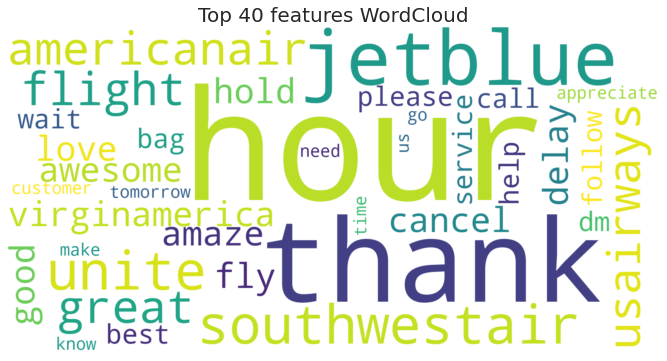

In [47]:
all_features = tfidf_vect.get_feature_names()              # Instantiate the feature from the vectorizer
top_features=''                                            # Addition of top 40 feature into top_feature after training the model
feat = rfc_tfidf.feature_importances_
features=np.argsort(feat)[::-1]
for i in features[0:40]:
    top_features+=all_features[i]
    top_features+=', '
    
print(top_features)  

print(" ") 
print(" ") 

from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white",colormap='viridis',width=2000, 
                          height=1000).generate(top_features)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.figure(1, figsize=(14, 11), frameon='equal')
plt.title('Top 40 features WordCloud', fontsize=20)
plt.axis("off")
plt.show()

### **Performance Comparison of Count Vectorizer and TFIDF Vectorizer**

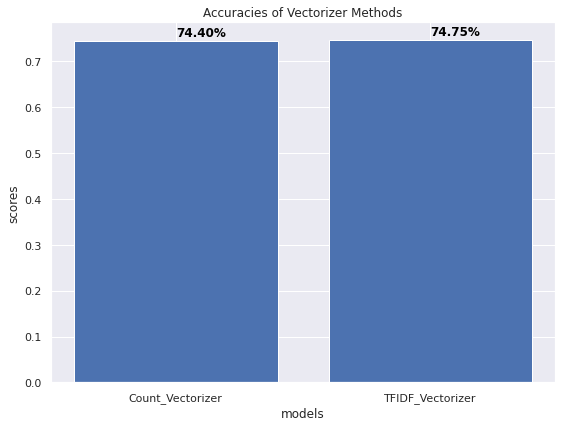

In [48]:
# create bar plot to compare the accuracies of Count Vectorizer and TF-IDF Vectorizer

import matplotlib.pyplot as plt
fig = plt.figure(figsize=(7,5))
ax = fig.add_axes([0,0,1,1])
subjects = ['Count_Vectorizer', 'TFIDF_Vectorizer']

# calculate accuracies of Count Vectorizer and TF-IDF Vectorizer using accuracy_score metrics
scores = [accuracy_score(y_test, count_predicted), accuracy_score(y_test, tfidf_predicted)]
ax.bar(subjects,scores)
ax.set_ylabel('scores',fontsize= 12)    # y axis label
ax.set_xlabel('models',fontsize= 12)    # x axis label
ax.set_title('Accuracies of Vectorizer Methods')  # title
for i, v in enumerate(scores):
    ax.text( i ,v+0.01, '{:.2f}%'.format(100*v), color='black', fontweight='bold')     
    plt.savefig('barplot_1.png',dpi=100, format='png', bbox_inches='tight')
plt.show()

#### **Observations**
- TF-IDF Vectorizer shows a slightly better model performance than Count Vectorizer.

## **Conclusion**

### **Summary**
- Overall, Random Forest modeling with TF-IDF Vectorizer shows slightly better performance than with Count Vectorizer. 
- TF-IDF not only focuses on the frequency of words present in the corpus but also provides the importance of the words. We can then remove the words that are less important for analysis, hence making the modeling less complex by reducing input dimensions.

### **Insights**
- Positive Sentiment seems to be more clearly distinguishable by the model.
- However the model seems to have trouble distinguishing between Negative Sentiment and Neutral Sentiment.
- One reason for this is perhaps Sentiment laced with sarcasm or other undertones which should be classified as Negative is misclassified as Neutral or worse Positive by the model.
- It would be interesting to see the model performance of various other classifiers including deep neural networks.
- We could apply other model tuning and hyperparameter tuning techniques, as well as other pre-processing techniques to increase the overall accuracy even further.